# Unpaired Lung CT 3d registration with MONAI

This tutorial shows how to use MONAI to register CT images acquired from different patient. The images are all from acquired at the same timepoint in the breathing cycle. This is an inter subject registration. This kind of registration is useful for determining how one stimulus affects multiple patients. If a drug or invasive procedure is administered to multiple patients, registering the images from different patients can give medical professionals a sense of how each patient is responding in comparison to others.

The usage of the following features are illustrated in this tutorial:
1. Load Nifti image with metadata
1. Transforms for dictionary format data
1. Build LocalNet
1. Transform dense velocity field (DVF) into dense displacement field (DDF) with DVF2DDF block.
1. Warp an image with given dense displacement field (DDF) with Warp block
1. Compute BendingEnergyLoss
1. Compute MeanDice metric

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_registration/paired_lung_ct.ipynb)

## Setup Environment
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/master/3d_registration/unpaired_lung_ct.ipynb)

In [4]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

Note: you may need to restart the kernel to use updated packages.


## Setup imports

In [ ]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import torch
import random
from torch.nn import MSELoss
from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import DataLoader, Dataset, CacheDataset
from monai.losses import BendingEnergyLoss
from monai.metrics import compute_meandice
from monai.networks.blocks import Warp, DVF2DDF
from monai.networks.nets import LocalNet
from monai.transforms import LoadImaged, AddChanneld, ToTensord, Compose, \
    ScaleIntensityRanged, RandAffined, Resized
from monai.utils import set_determinism, first

print_config()

MONAI version: 0.5.dev2114
Numpy version: 1.19.2
Pytorch version: 1.8.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False
MONAI rev id: d6faa335662624c95e0ada2fcfe803ca1397f4a4

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 3.2.1
scikit-image version: NOT INSTALLED or UNKNOWN VERSION.
Pillow version: 8.1.2
Tensorboard version: 2.4.1
gdown version: 3.12.2
TorchVision version: 0.9.0
ITK version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.59.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
# root_dir = tempfile.mkdtemp() if directory is None else directory
root_dir = '/tmp/tmpmawhng7p'
print(root_dir)

/tmp/tmpmawhng7p


## Download dataset

Download and extract the dataset

In [6]:
resource = "https://zenodo.org/record/3835682/files/training.zip"

compressed_file = os.path.join(root_dir, "paired_ct_lung.zip")
data_dir = os.path.join(root_dir, "paired_ct_lung")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)
    os.rename(os.path.join(root_dir, "training"), data_dir)

## Set dataset path
Only images at the expiration time point are used.

In [7]:
train_files = []
for _ in range(100):
    fix_id, moving_id = random.sample([i for i in range(1, 19)], 2)
    train_files.append(
        {
            "fixed_image": os.path.join(data_dir, "scans/case_%03d_exp.nii.gz" % fix_id),
            "moving_image": os.path.join(data_dir, "scans/case_%03d_exp.nii.gz" % moving_id),
        }
    )

val_files = [
    {
        "fixed_image": os.path.join(data_dir, "scans/case_%03d_exp.nii.gz" % fix_id),
        "moving_image": os.path.join(data_dir, "scans/case_%03d_exp.nii.gz" % moving_id),
        "fixed_label": os.path.join(data_dir, "lungMasks/case_%03d_exp.nii.gz" % fix_id),
        "moving_label": os.path.join(data_dir, "lungMasks/case_%03d_exp.nii.gz" % moving_id)
    }
    for fix_id, moving_id in [(18, 19), (19, 20)]
]

## Set deterministic training for reproducibility

In [8]:
set_determinism(seed=0)

## Setup transforms for training and validation
Here we use several transforms to augment the dataset:
1. LoadImaged loads the lung CT images and labels from NIfTI format files.
2. AddChanneld as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
3. ScaleIntensityRanged extracts intensity range [-57, 164] and scales to [0, 1].
4. RandAffined efficiently performs rotate, scale, shear, translate, etc. together based on PyTorch affine transform.
5. Resized resize images to the same size.
6. ToTensord converts the numpy array to PyTorch Tensor for further steps.

In [9]:
train_transforms = Compose(
    [
        LoadImaged(
            keys=["fixed_image", "moving_image"]
        ),
        AddChanneld(
            keys=["fixed_image", "moving_image"]
        ),
        ScaleIntensityRanged(
            keys=["fixed_image", "moving_image"],
            a_min=-285, a_max=3770, b_min=0.0, b_max=1.0, clip=True,
        ),
        RandAffined(
            keys=["fixed_image", "moving_image"],
            mode=('bilinear', 'bilinear'),
            prob=1.0, spatial_size=(192, 192, 208),
            rotate_range=(0, 0, np.pi / 15), scale_range=(0.1, 0.1, 0.1)
        ),
        Resized(
            keys=["fixed_image", "moving_image"],
            mode=('trilinear', 'trilinear'),
            align_corners=(True, True),
            spatial_size=(96, 96, 104)
        ),
        ToTensord(
            keys=["fixed_image", "moving_image"]
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"]
        ),
        AddChanneld(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"]
        ),
        ScaleIntensityRanged(
            keys=["fixed_image", "moving_image"],
            a_min=-285, a_max=3770, b_min=0.0, b_max=1.0,
            clip=True,
        ),
        Resized(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            mode=('trilinear', 'trilinear', 'nearest', 'nearest'),
            align_corners=(True, True, None, None),
            spatial_size=(96, 96, 104)
        ),
        ToTensord(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"]
        ),
    ]
)

## Check transforms in DataLoader
Visulize a single training batch to check the transforms.

moving_image shape: torch.Size([96, 96, 104]),  fixed_image shape: torch.Size([96, 96, 104]).


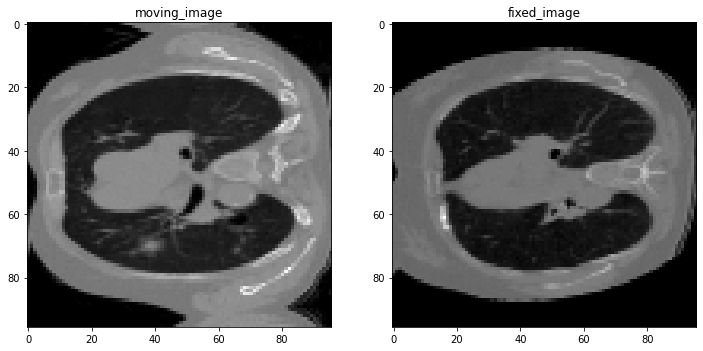

In [10]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
fixed_image = check_data["fixed_image"][0][0]
moving_image = check_data["moving_image"][0][0]

print(f"moving_image shape: {moving_image.shape}, ",
      f"fixed_image shape: {fixed_image.shape}.")

# plot the slice [:, :, 50]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("moving_image")
plt.imshow(moving_image[:, :, 50], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("fixed_image")
plt.imshow(fixed_image[:, :, 50], cmap="gray")

plt.show()

Visulize a single validation batch to check the transforms.

moving_image shape: torch.Size([96, 96, 104]), moving_label shape: torch.Size([96, 96, 104])
fixed_image shape: torch.Size([96, 96, 104]), fixed_label shape: torch.Size([96, 96, 104])


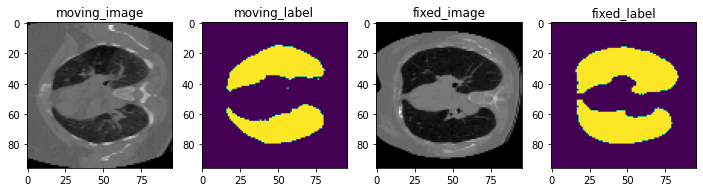

In [11]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
fixed_image = check_data["fixed_image"][0][0]
fixed_label = check_data["fixed_label"][0][0]
moving_image = check_data["moving_image"][0][0]
moving_label = check_data["moving_label"][0][0]

print(f"moving_image shape: {moving_image.shape}, "
      f"moving_label shape: {moving_label.shape}")
print(f"fixed_image shape: {fixed_image.shape}, "
      f"fixed_label shape: {fixed_label.shape}")

# plot the slice [:, :, 50]
plt.figure("check", (12, 6))
plt.subplot(1, 4, 1)
plt.title("moving_image")
plt.imshow(moving_image[:, :, 50], cmap="gray")
plt.subplot(1, 4, 2)
plt.title("moving_label")
plt.imshow(moving_label[:, :, 50])
plt.subplot(1, 4, 3)
plt.title("fixed_image")
plt.imshow(fixed_image[:, :, 50], cmap="gray")
plt.subplot(1, 4, 4)
plt.title("fixed_label")
plt.imshow(fixed_label[:, :, 50])

plt.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.
To achieve best performance, set cache_rate=1.0 to cache all the data, if memory is not enough, set lower value.
Users can also set cache_num instead of cache_rate, will use the minimum value of the 2 settings.
And set num_workers to enable multi-threads during caching.
If want to to try the regular Dataset, just change to use the commented code below.


In [12]:
train_ds = CacheDataset(data=train_files, transform=train_transforms,
                        cache_rate=1.0, num_workers=4)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)

val_ds = CacheDataset(data=val_files, transform=val_transforms,
                      cache_rate=1.0, num_workers=0)

val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|██████████| 2/2 [00:01<00:00,  1.24it/s]


#### Create Model, Loss, Optimizer

In [13]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:2")
model = LocalNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=3,
    num_channel_initial=32,
    extract_levels=[0, 1, 2, 3],
    out_activation=None,
    out_kernel_initializer="zeros").to(device)
dvf2ddf = DVF2DDF()
warp_layer = Warp().to(device)
image_loss = MSELoss()
regularization = BendingEnergyLoss()
optimizer = torch.optim.Adam(model.parameters(), 1e-5)

/home/kate/anaconda3/envs/monai_tutorial/lib/python3.7/site-packages/monai/networks/blocks/warp.py:69: UserWarning: monai.networks.blocks.Warp: Using PyTorch native grid_sample.
  warnings.warn("monai.networks.blocks.Warp: Using PyTorch native grid_sample.")


Define a forward pass function for DVF computation, DVF to DDF transform and warping to avoid duplicate coding.

In [14]:
def forward(batch_data, model, dvf2ddf, val=False):
    fixed_image = batch_data["fixed_image"].to(device)
    moving_image = batch_data["moving_image"].to(device)
    dvf = model(torch.cat((moving_image, fixed_image), dim=1))
    ddf = dvf2ddf(dvf)
    ddf = dvf
    pred_image = warp_layer(moving_image, ddf)
    if val:
        moving_label = batch_data["moving_label"].to(device)
        pred_label = warp_layer(moving_label, ddf)
    else:
        pred_label = None
    return ddf, pred_image, pred_label

## Execute a typical PyTorch training process
Due to long training time required to for the model to converge, we provide a training snippet that trains for only 5 epochs to illustrate the training process. Pretrained weight which has been trained for 2000 epochs are provided in the inference section to illustrated the final performance. If want to train by yourself, simply change epoch_num to 2000.

In [ ]:
val_period = 1
epoch_num = 5
val_interval = 1
best_metric = -1
best_metric_epoch = -1
loss_values = []
metric_values = []

loss_sum = 0

for epoch in range(epoch_num):

    if (epoch + 1) % val_period == 0 or epoch == 0:
        loss_values.append(loss_sum / val_period)
        loss_sum = 0
        model.eval()
        with torch.no_grad():
            metric_sum = 0.0
            metric_count = 0
            for val_data in val_loader:

                val_ddf, val_pred_image, val_pred_label = forward(
                    val_data, model, dvf2ddf, val=True)

                val_fixed_image = val_data["fixed_image"].to(device)
                val_fixed_label = val_data["fixed_label"].to(device)
                value = compute_meandice(
                    y_pred=val_pred_label,
                    y=val_fixed_label,
                    include_background=False,
                )
                metric_count += len(value)
                metric_sum += value.sum().item()

            metric = metric_sum / metric_count
            metric_values.append(metric)
            if metric > best_metric:
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(),
                           os.path.join(root_dir, "best_metric_model.pth"))
                print("saved new best metric model")
            print(
                f"current metric: {metric:.4f}\n"
                f"best metric: {best_metric:.4f} "
                f"at epoch: {best_metric_epoch}"
            )
        model.train()

    for step, batch_data in enumerate(train_loader):
        optimizer.zero_grad()

        ddf, pred_image, _ = forward(batch_data, model, dvf2ddf)

        fixed_image = batch_data["fixed_image"].to(device)
        loss = 100 * image_loss(pred_image, fixed_image) + 10 * regularization(ddf)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
    print(f"{epoch}/{epoch_num}, "
          f"train_loss: {loss_sum / (step + 1):.4f}")

In [ ]:
print(f"train completed, "
      f"best_metric: {best_metric:.4f}  "
      f"at step: {best_metric_epoch}")

#### Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [(i + 1) * val_period for i in range(len(loss_values))]
y = loss_values
plt.xlabel("step")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Image Similarity")
x = [(i + 1) * val_period for i in range(len(metric_values))]
y = metric_values
plt.xlabel("step")
plt.plot(x, y)
plt.show()

#### Check best model output with the input image and label

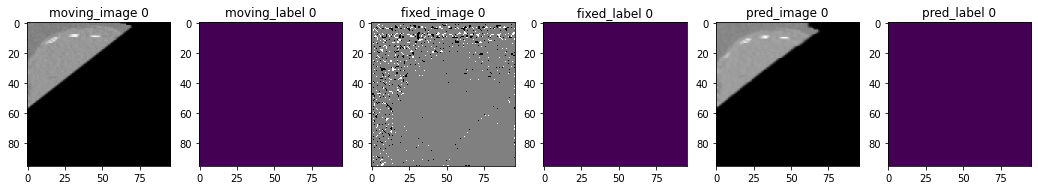

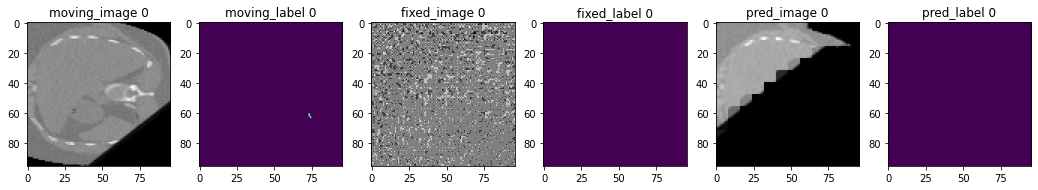

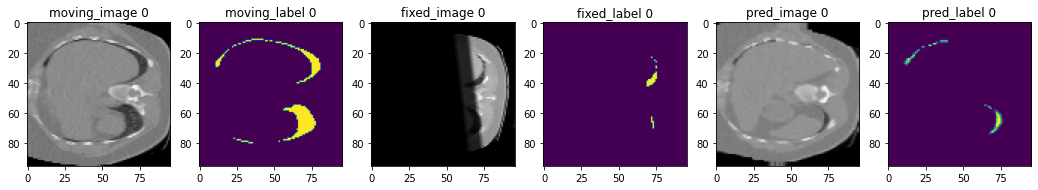

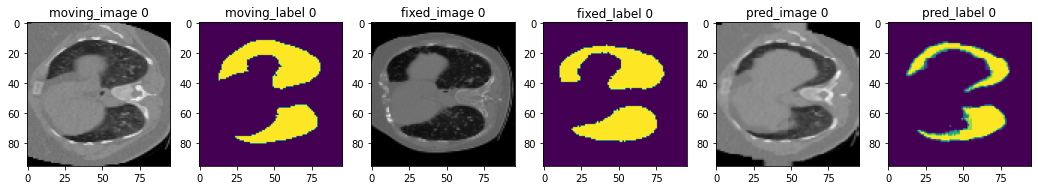

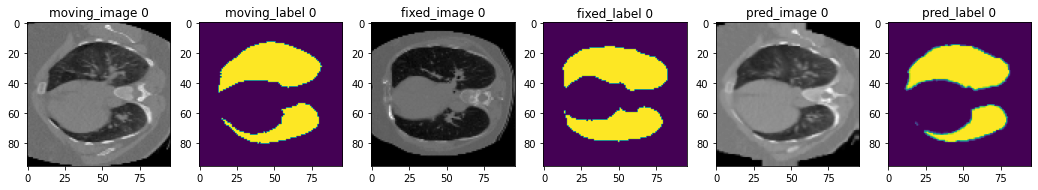

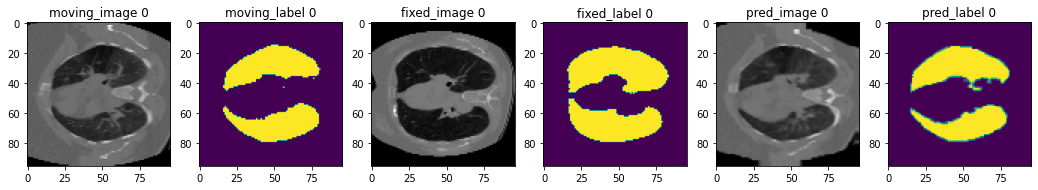

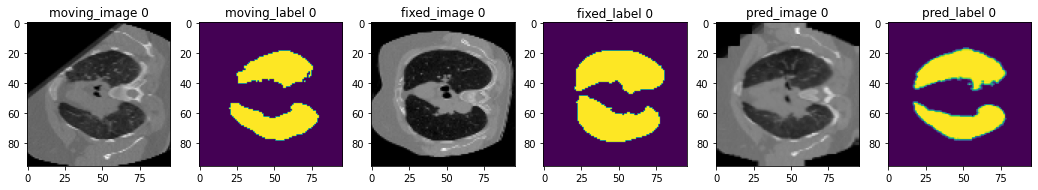

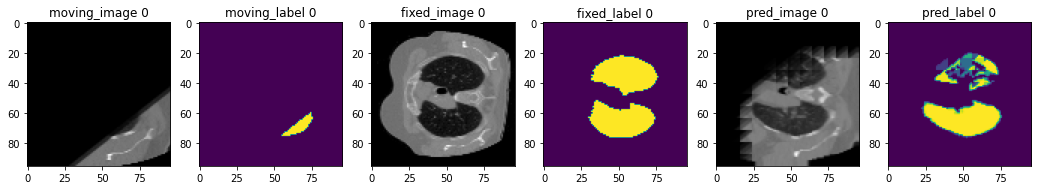

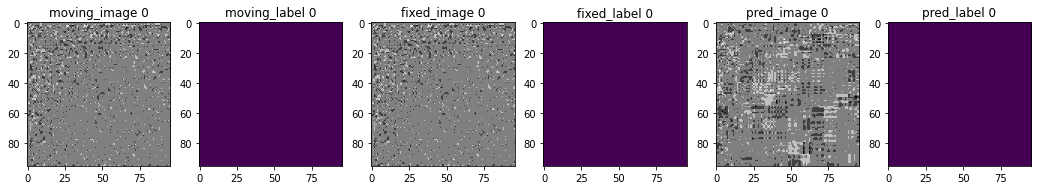

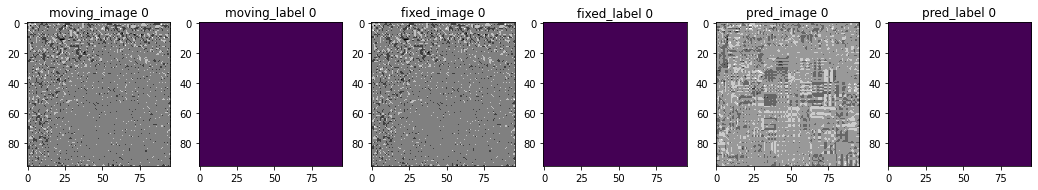

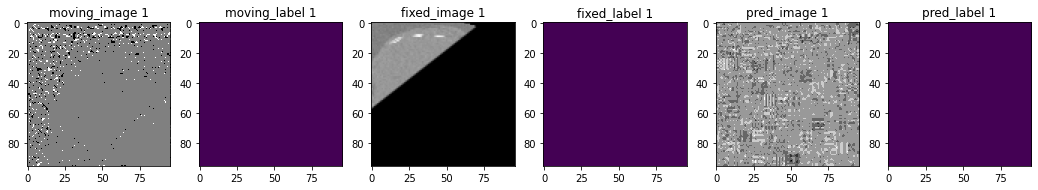

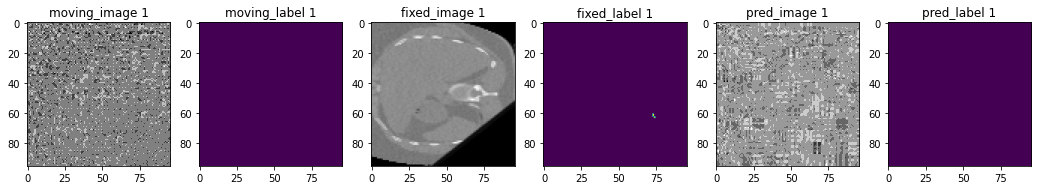

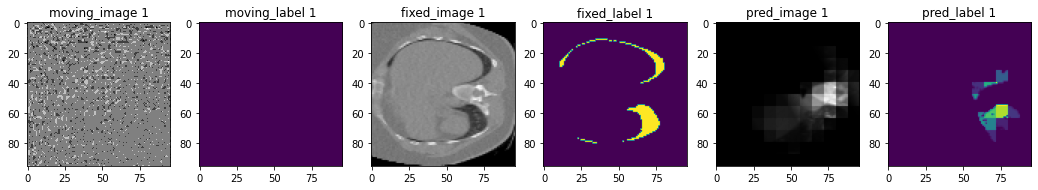

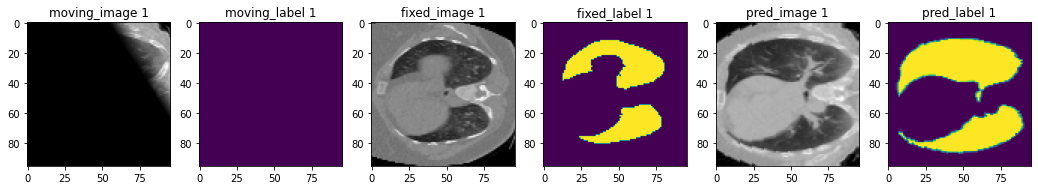

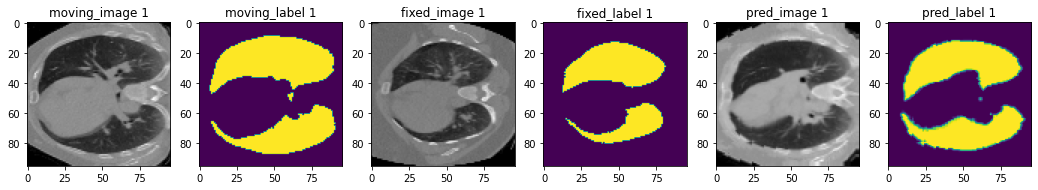

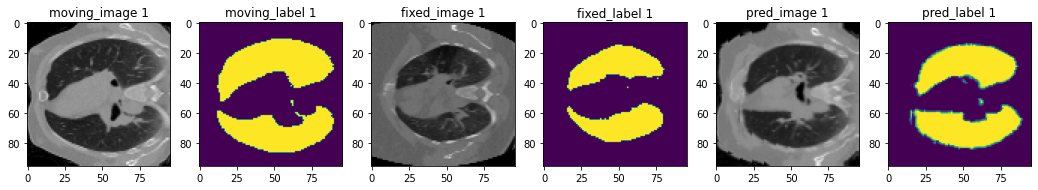

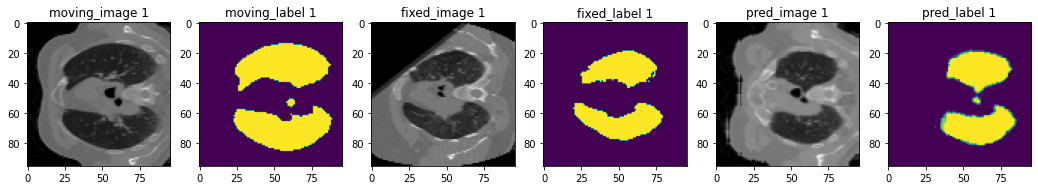

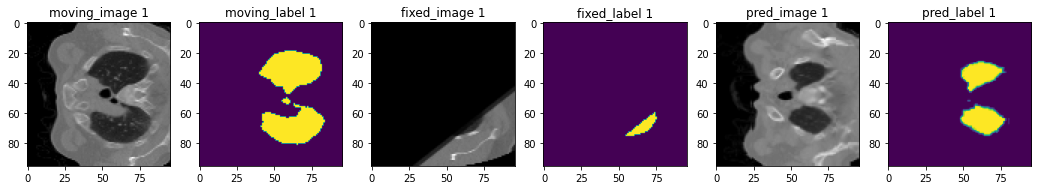

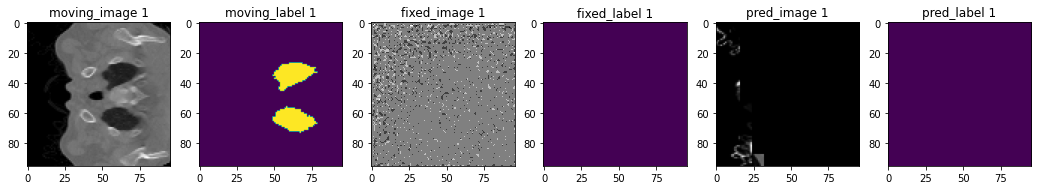

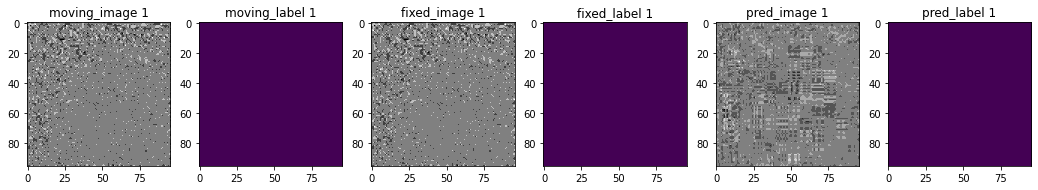

In [15]:
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        val_ddf, val_pred_image, val_pred_label = forward(val_data, model, dvf2ddf, val=True)
        val_ddf = val_ddf.cpu().numpy()
        val_pred_image = val_pred_image.cpu().numpy()
        val_pred_label = val_pred_label.cpu().numpy()

        for depth in range(10):
            depth = depth * 10

            plt.figure("check", (18, 6))
            plt.subplot(1, 6, 1)
            plt.title(f"moving_image {i}")
            plt.imshow(val_data["moving_image"][0, 0, :, :, depth], cmap="gray")
            plt.subplot(1, 6, 2)
            plt.title(f"moving_label {i}")
            plt.imshow(val_data["moving_label"][0, 0, :, :, depth])
            plt.subplot(1, 6, 3)
            plt.title(f"fixed_image {i}")
            plt.imshow(val_data["fixed_image"][0, 0, :, :, depth], cmap="gray")
            plt.subplot(1, 6, 4)
            plt.title(f"fixed_label {i}")
            plt.imshow(val_data["fixed_label"][0, 0, :, :, depth])
            plt.subplot(1, 6, 5)
            plt.title(f"pred_image {i}")
            plt.imshow(val_pred_image[0, 0, :, :, depth], cmap="gray")
            plt.subplot(1, 6, 6)
            plt.title(f"pred_label {i}")
            plt.imshow(val_pred_label[0, 0, :, :, depth])
            plt.show()

#         # plot the slice [:, :, 80]
#         plt.figure("check", (18, 6))
#         plt.subplot(1, 3, 1)
#         plt.title(f"moving_image {i}")
#         plt.imshow(val_data["moving_image"][0, 0, :, :, 50], cmap="gray")
#         plt.subplot(1, 3, 2)
#         plt.title(f"fixed_image {i}")
#         plt.imshow(val_data["fixed_image"][0, 0, :, :, 50], cmap="gray")
#         plt.subplot(1, 3, 3)
#         plt.title(f"pred_image {i}")
#         plt.imshow(val_pred_image[0, 0, :, :, 50], cmap="gray")
#         plt.show()

## Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)
